In [10]:
import torch
import numpy as np
from scipy.spatial.distance import cdist, cosine
import chess.engine
from os import path, getcwd
from random import randint

import settings
from model import Autoencoder
from inference import Inference
from board_similarity import predict_similarity
from evaluation import model_score
import matplotlib.pyplot as plt

In [11]:
batch_size = 15
n_fens_to_test = 5000

In [12]:
# Similarity functions
model_similarity_functions = {}

def nearest(matrix, target):
    return cdist(np.array(matrix), np.atleast_2d([target]))
def l1_loss(matrix, target):
    return [np.sum(np.abs(np.array(m) - np.array(target))) for m in matrix]
def cosine_dist(matrix, target):
    return [cosine(m, target) for m in matrix]
    
model_similarity_functions["Nearest"] = nearest
model_similarity_functions["L1 loss"] = l1_loss
model_similarity_functions["Cosine dist"] = cosine_dist

In [13]:
# Models inference
models_inference = {}

class RandomEmbeding():
    def predict(self,y):
        return torch.rand(len(y),16)
models_inference["Random Tensors"] = RandomEmbeding()

coder = Autoencoder(settings.BOARD_SHAPE, settings.LATENT_SIZE).to(settings.DEVICE)
coder.load_state_dict(torch.load("final_model.pth", map_location=settings.DEVICE))
coder = coder.coder
coder.eval()
inf = Inference(settings.DEVICE, coder)

models_inference["Model1"] = inf

coder2 = Autoencoder(settings.BOARD_SHAPE, settings.LATENT_SIZE).to(settings.DEVICE)
coder2 = coder2.coder
coder2.eval()
inf2 = Inference(settings.DEVICE, coder2)

models_inference["Random Model"] = inf2



In [14]:
# chess engine
engine = chess.engine.SimpleEngine.popen_uci(
        path.join(getcwd(), "stockfish_13_win_x64", "stockfish_13_win_x64.exe")
    )

In [15]:
# Get test fens

fens = None
with open("test_fens.pgn", "r") as f:
    read = f.read().split("\n")
    fens = read[:min(n_fens_to_test,len(read))]
    del read
print(fens[0])

rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1


Model : Random Tensors || Function : Nearest
 Progres : 100%, End
Model : Random Tensors || Function : L1 loss
 Progres : 100%, End
Model : Random Tensors || Function : Cosine dist
 Progres : 100%, End


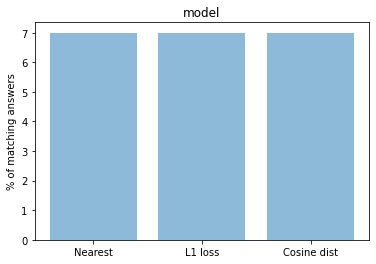

Best result for Random Tensors :  7 

Model : Model1 || Function : Nearest
 Progres : 100%, End
Model : Model1 || Function : L1 loss
 Progres : 100%, End
Model : Model1 || Function : Cosine dist
 Progres : 100%, End


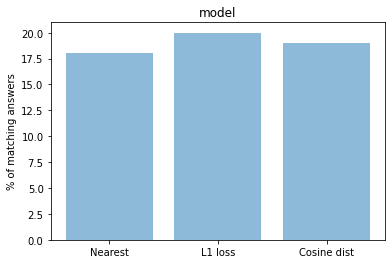

Best result for Model1 :  20 

Model : Random Model || Function : Nearest
 Progres : 100%, End
Model : Random Model || Function : L1 loss
 Progres : 100%, End
Model : Random Model || Function : Cosine dist
 Progres : 100%, End


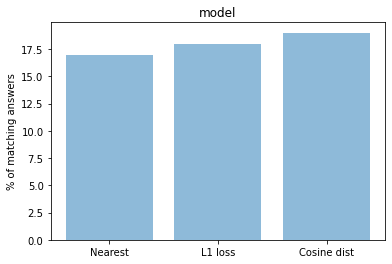

Best result for Random Model :  19 



In [16]:
for model in models_inference:
    results = []
    for similarity in model_similarity_functions:
        print("Model : "+model,"|| Function : "+similarity)
        results.append(int(100*model_score(models_inference[model], engine, model_similarity_functions[similarity], predict_similarity, fens.copy(), batch_size,print_progress = True)))
    y_pos = np.arange(len(model_similarity_functions))
    plt.bar(y_pos, results, align='center', alpha=0.5)
    plt.xticks(y_pos, list(model_similarity_functions))
    plt.ylabel('% of matching answers')
    plt.title(model)
    plt.show()
    print("Best result for "+model+" : ", max(results),"\n")
